# Queue Management

* The queue is used to task labelers with specific examples
* We can do any of the following:
    * Set the number of times we want an image labeled
        * Referred to as `Consensus` in the front end
    * Set the order of items in the queue
    * Set the percent of assets to review

In [ ]:
!pip install labelbox
!pip install PILLOW
!pip install numpy

In [3]:
from labelbox import Client, LabelingFrontend
from labelbox.schema.ontology import OntologyBuilder
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from io import BytesIO
from getpass import getpass
import os

In [ ]:
# If you don't want to give google access to drive you can skip this cell
# and manually set `API_KEY` below.

COLAB = "google.colab" in str(get_ipython())
if COLAB:
    !pip install colab-env -qU
    from colab_env import envvar_handler
    envvar_handler.envload()

API_KEY = os.environ.get("LABELBOX_API_KEY")
if not os.environ.get("LABELBOX_API_KEY"):
    API_KEY = getpass("Please enter your labelbox api key")
    if COLAB:
        envvar_handler.add_env("LABELBOX_API_KEY", API_KEY)

In [4]:
# Only update this if you have an on-prem deployment
ENDPOINT = "https://api.labelbox.com/graphql"

In [5]:
client = Client(api_key=API_KEY, endpoint=ENDPOINT)

### Set up demo project

In [6]:
# We are going to create a new project for this
# Checkout the project_setup notebook for more details on this cell.
project = client.create_project(name="queue_project")
dataset = client.create_dataset(name="queue_dataset")
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == 'editor'))
project.setup(editor,
              OntologyBuilder().asdict()
             )  #empty ontology since we aren't actually labeling..
project.datasets.connect(dataset)

In [7]:
def make_digit_image(digit: int) -> np.ndarray:
    """
    Will draw a while number on a black image
    
    Args:
        digit (int): number to draw
    Returns:
        numpy array with digit drawn
    """
    font = ImageFont.truetype("Verdana.ttf", 128)
    img = Image.fromarray(np.zeros((500, 500, 3), dtype=np.uint8))
    draw = ImageDraw.Draw(img)
    draw.text((200, 180), str(digit), font=font)
    return img

In [8]:
# Ok let's add these to the project
for idx in range(15):
    img = make_digit_image(idx + 1)
    img_bytes = BytesIO()
    img.save(img_bytes, format="jpeg")
    row_data = client.upload_data(img_bytes.getvalue(),
                                  content_type='image/jpeg')
    dataset.create_data_row(row_data=row_data, external_id=f"queue_{idx + 1}")

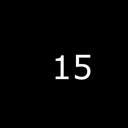

In [9]:
#Example image
img.resize((128, 128))

# Set Queue Order

In [10]:
data_rows = list(dataset.data_rows())
#project.set_labeling_parameter_overrides(data)

In [11]:
priorities = []
for data_row in data_rows:
    priorities.append((data_row, int(data_row.external_id.split('_')[-1]), 1))

In [12]:
#Ordered by external_id
for priority in priorities:
    print(priority)

(<DataRow ID: ckmv2hx1a08y80y9qflz7dcrj>, 1, 1)
(<DataRow ID: ckmv2hxsw08sw0y8h2xnc95g7>, 2, 1)
(<DataRow ID: ckmv2hydt08t20y8h11bf04l9>, 3, 1)
(<DataRow ID: ckmv2hz0h08tb0y8h3mnl6n0l>, 4, 1)
(<DataRow ID: ckmv2hzmf08yu0y9q6c0l03ex>, 5, 1)
(<DataRow ID: ckmv2i09o09dd0y8u5wgy13b7>, 6, 1)
(<DataRow ID: ckmv2i14z08z90y9qeuyy462i>, 7, 1)
(<DataRow ID: ckmv2i1tf09dm0y8uc4q0bg38>, 8, 1)
(<DataRow ID: ckmv2i2nh08ur0y8hb7yhh7s3>, 9, 1)
(<DataRow ID: ckmv2i3cd09dv0y8u883t21xy>, 10, 1)
(<DataRow ID: ckmv2i3zi08v70y8h2uhe3n57>, 11, 1)
(<DataRow ID: ckmv2i4s208zq0y9qbz0fa67y>, 12, 1)
(<DataRow ID: ckmv2i5pm08vm0y8h1d8genuc>, 13, 1)
(<DataRow ID: ckmv2i69e09e70y8uaq3adowb>, 14, 1)
(<DataRow ID: ckmv2i6u709ec0y8uaf4mdnfv>, 15, 1)


In [13]:
project.set_labeling_parameter_overrides(priorities)

True

* <b>Go to your project and you should see the numbers appear in order.</b>

In [14]:
print("View the results here:",
      f"https://app.labelbox.com/projects/{project.uid}")
# Click `start labeling` to see the images in order

View the results here: https://app.labelbox.com/projects/ckmv2hun5cy640789au25hgr9


### Set number of duplicates
* Here we set a duplicate of 2.
* If you have two accounts to log into the project from, both users will get the same 15 images in order.
* Even from one account you will see it works by skipping a single image and then go to the project overview
    * You will see 29 remaining with 1 skipped (15 images 2 copies of each).

In [21]:
# Images will still be labeled in the same order (determined by p[1])
# But now each image will be labeled 2 times (never by the same user.
# (If you don't have at least 3 users the items will remain in the queue.)
duplicate_priorities = [(p[0], p[1], 2) for p in priorities]
project.set_labeling_parameter_overrides(duplicate_priorities)

True

### Remove Queue Order
* This will delete all of the priorities
* Duplicates in the queue will also be cleared

In [22]:
project.unset_labeling_parameter_overrides(data_rows)

True

* Go to the project and you will see 14 remaining with 1 skipped (was 29.)

### Review Queue
* Set the percent of labels to be reviewed 

In [25]:
# You can set the percent of labels to be sent to the review queue by running
# Can be 0 to 1 representing 0 to 100%
project.upsert_review_queue(0.2)

* Go to the project at the bottom you will see the `training data quality` section.
* Coverage should be 20%